# 1. Introduction

# 2. Import Library

In [1]:
# for data manipulation
import pandas as pd 
import numpy as np

# for data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# for model buidling
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from tensorflow.keras.utils import plot_model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TextVectorization, Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# for model evaluation
from sklearn.metrics import classification_report

# for text preprocess
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')

# hide all warnings
import warnings
warnings.filterwarnings('ignore')

# show all columns
pd.options.display.max_columns = None

2024-07-02 23:20:28.753441: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nathanaelh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nathanaelh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# 3. Data Loading 

In [2]:
data = pd.read_csv('data/consumer_complaints_labeled.csv')

In [3]:
data.head()

,sentence,light_complaints,harsh_complaints,mild_complaints
0,Can't stop charges to bank account Can't stop ...,0,1,1
1,Cont'd attempts collect debt not owed Debt is ...,0,0,1
2,Disclosure verification of debt Right to dispu...,0,0,1
3,Cont'd attempts collect debt not owed Debt is ...,0,1,1
4,Cont'd attempts collect debt not owed Debt is ...,1,1,0


# 4. Feature Engineering

## a. Text Preprocessing

In [4]:
# Define Stopwords
stop_words = set(stopwords.words('english'))

# Define Stemming
lemmatizer = WordNetLemmatizer()

The code above sets up the necessary components for text preprocessing in NLP by defining a set of stopwords and initializing a lematizer tool.

In [5]:
# Create A Function for Text Preprocessing
def text_preprocessing(text):
  # Case folding
  text = text.lower()

  # Mention removal
  text = re.sub("@[A-Za-z0-9_]+", " ", text)

  # Hashtags removal
  text = re.sub("#[A-Za-z0-9_]+", " ", text)

  # Newline removal (\n)
  text = re.sub(r"\\n", " ",text)

  # Whitespace removal
  text = text.strip()

  # URL removal
  text = re.sub(r"http\S+", " ", text)
  text = re.sub(r"www.\S+", " ", text)

  # Non-letter removal (such as emoticon, symbol (like μ, $, 兀), etc
  text = re.sub("[^A-Za-z\s']", " ", text)
  text = re.sub("'", "", text)

  # Tokenization
  tokens = word_tokenize(text)

  # Stopwords removal
  tokens = [word for word in tokens if word not in stop_words]

  # Stemming
  tokens = [lemmatizer.lemmatize(word) for word in tokens]

  # Combining Tokens
  text = " ".join(tokens)

  return text

The `text_preprocessing` function cleans and processes text to prepare it for modeling. 

It converts the text to lowercase, removes hashtags, newline characters, extra whitespace, and non-letter characters (like emoticons and symbols). It then tokenizes the text into individual words, removes common stopwords, and applies lematizing to reduce words to their root forms. 

Finally, it combines the processed tokens back into a single string and returns the cleaned text. This preprocessing helps in standardizing the text for further natural language processing tasks.

In [6]:
data['sentence_processed'] = data['sentence'].apply(lambda x: text_preprocessing(x))
data

,sentence,light_complaints,harsh_complaints,mild_complaints,sentence_processed
0,Can't stop charges to bank account Can't stop ...,0,1,1,cant stop charge bank account cant stop charge...
1,Cont'd attempts collect debt not owed Debt is ...,0,0,1,contd attempt collect debt owed debt mine dent...
2,Disclosure verification of debt Right to dispu...,0,0,1,disclosure verification debt right dispute not...
3,Cont'd attempts collect debt not owed Debt is ...,0,1,1,contd attempt collect debt owed debt mine disp...
4,Cont'd attempts collect debt not owed Debt is ...,1,1,0,contd attempt collect debt owed debt mine reac...
...,...,...,...,...,...
2216,Disclosure verification of debt Not given enou...,0,1,1,disclosure verification debt given enough info...
2217,Cont'd attempts collect debt not owed Debt was...,0,0,1,contd attempt collect debt owed debt paid xxxx...
2218,Taking/threatening an illegal action Threatene...,0,1,0,taking threatening illegal action threatened a...
2219,False statements or representation Attempted t...,0,0,1,false statement representation attempted colle...


## b. Train Test Split

In [7]:
sentence = data['sentence_processed']

labels = data[['light_complaints', 'harsh_complaints', 'mild_complaints']]

The data is separated into sentence and label, `sentence` consist of `sentence_processed` that been preprocessed before, and `labels` consist of `light_complaints`, `harsh_complaints`, and `mild_complaints`.

In [8]:
# Data Splitting
X_train_val, X_test, y_train_val, y_test = train_test_split(sentence,
                                                    labels,
                                                    test_size=0.15,
                                                    random_state=20,
                                                    stratify=labels)

X_train, X_val, y_train, y_val = train_test_split(X_train_val,
                                                  y_train_val,
                                                  test_size=0.10,
                                                  random_state=20,
                                                  stratify=y_train_val)

print('Train Size : ', X_train.shape)
print('Val Size   : ', X_val.shape)
print('Test Size  : ', X_test.shape)

Train Size :  (1698,)
Val Size   :  (189,)
Test Size  :  (334,)


The data is split into training, validation, and test sets to prepare for model building and evaluation. 

Initially, 85% of the data is allocated to the training/validation set, and 15% to the test set, ensuring the class distribution remains the same by stratifying to labels. Then, the training/validation set is further split, with 10% set aside for validation. 

The final sizes of the datasets are 1698 samples for training, 189 for validation, and 334 for testing. This setup helps ensure that the model can be properly trained, tuned, and evaluated.

## c. Finding Number of Vocab and Max Token Lenght


In [9]:
# Vectorize Text
Vectorize = CountVectorizer()
X_train_vec = Vectorize.fit_transform(X_train)
X_val_vec = Vectorize.transform(X_val)
X_test_vec = Vectorize.transform(X_test)

# Show vectorized X_train
X_train_vec

<1698x6706 sparse matrix of type '<class 'numpy.int64'>'
	with 96817 stored elements in Compressed Sparse Row format>

In [10]:
# Finding the Number of Vocabs and Max Token Length in One Document
total_vocab = len(Vectorize.vocabulary_.keys())
max_sen_len = max([len(i.split(" ")) for i in X_train])

print('Total Vocab : ', total_vocab)
print('Maximum Sentence Length : ', max_sen_len, 'tokens')

Total Vocab :  6706
Maximum Sentence Length :  400 tokens


The `CountVectorizer` from `scikit-learn` is used to transform the text data into a matrix of token counts.

The total number of unique words (vocabulary) in the training set is calculated from the `Vectorizer` vocabulary giving output 6706 of total vocab.

The maximum number of tokens (words) in any single document (sentence) in the training set is determined by splitting each document into words and finding the longest one giving output of 400 tokens.

## d. Text Vectorization

In [11]:
# Text Vectorization
text_vectorization = TextVectorization(max_tokens=10000,
                                       standardize="lower_and_strip_punctuation",
                                       split="whitespace",
                                       ngrams=None,
                                       output_mode="int",
                                       output_sequence_length=max_sen_len,
                                       input_shape=(1,)) # Only use in Sequential API

text_vectorization.adapt(X_train)

The code sets up a text vectorization process using TensorFlow's `TextVectorization` layer. It configures the layer to convert text to lowercase, remove punctuation, split text by whitespace, and limit the vocabulary to the unique words found in the training data. The text is then tokenized into integers, with sequences padded or truncated to the length of the longest sentence. 

The layer is adapted to the training data to learn its vocabulary, preparing the text for input into a neural network.

## e. Embedding

In [13]:
# Embedding
embedding = Embedding(input_dim=10000,
                      output_dim=128,
                      embeddings_initializer="uniform"
                      )

The code creates an embedding layer for a neural network using TensorFlow. This layer converts input text into dense 128-dimensional vectors. The `input_dim` parameter is set to 10000, ensuring that each unique word has a corresponding vector.

The embeddings are initialized uniform, meaning the initial values of the vectors are uniformly distributed. This embedding layer helps the model learn meaningful representations of words during training.

In [14]:
## Document example
print('Document example')
print(data.sentence_processed[0])
print('')

## Result of Text Vectorization
print('Result of Text Vectorization')
print(text_vectorization([data.sentence_processed[0]]))
print('Vector size : ', text_vectorization([data.sentence_processed[0]]).shape)

## Result of  Embedding
print('Result of  Embedding')
print(embedding(text_vectorization([data.sentence_processed[0]])))
print('Vector size : ', embedding(text_vectorization([data.sentence_processed[0]])).shape)

Document example
cant stop charge bank account cant stop charge bank account took loan cash central xxxx al sense time lost job also medication went roof unable pay loan back every sense time receiving phone call everyday day pas calling always call different number never know calling caused pay much money bank time bank xxxx xxxx xxxx al caused pay hundred dollar overdraft fee money could paid would stop trying debit account call every day starting around xxxx telling thing time call money pay money would pay month paid income increase able pay fix income pay tell pay nt know self tired harassing phone call xxxx xxxx every day get worse worse ca nt keep putting calling every day like work nerve set really bad told xxxx people call would try pay something next month screamed said next month next month told see bill would run could give amount much pay know even could pay would dollar much keep calling calling every day pas month ca nt take longer nerve bad run xxxx xxxx calling every d

# 5. Model Building

In this step, we will define our base ANN model to be trained by using train set, and then we will evaluate the performance of the base model. The next step is for us to improve our base model by changing the model architecture or set some parameters to improve the performance of base model.

## a. Model Definition

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 400)               0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 400, 128)          1280000   
                                                                 
 lstm (LSTM)                 (None, 400, 128)          131584    
                                                                 
 lstm_1 (LSTM)               (None, 400, 64)           49408     
                                                                 
 lstm_2 (LSTM)               (None, 400, 32)           12416     
                                                                 
 lstm_3 (LSTM)               (None, 8)                 1312      
                                                        

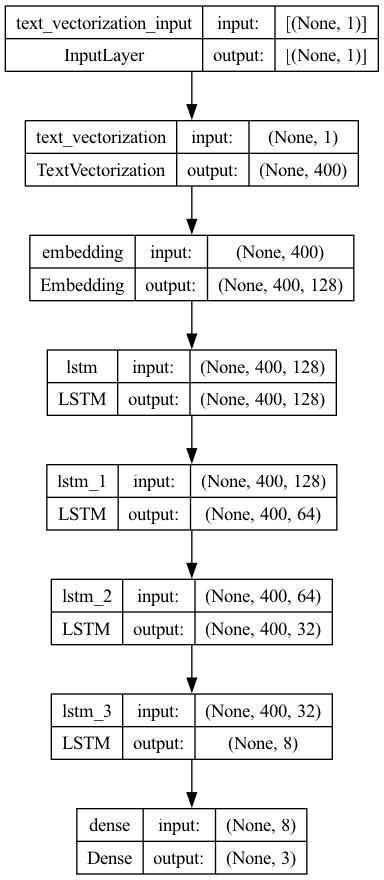

In [26]:
## Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

# Define the architecture
model_lstm_1 = Sequential()
model_lstm_1.add(text_vectorization)
model_lstm_1.add(embedding)
model_lstm_1.add(LSTM(128, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed)))  
model_lstm_1.add(LSTM(64, return_sequences=True))  # Avoiding custom initializers for compatibility
model_lstm_1.add(LSTM(32, return_sequences=True))
model_lstm_1.add(LSTM(8))
model_lstm_1.add(Dense(3, activation='sigmoid'))

# Ensure loss function is correct
model_lstm_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_lstm_1.summary()

# plot the model
plot_model(model_lstm_1, show_shapes=True, show_layer_names=True)

## b. Model Training

In [27]:
# Assign callback to speed up computing and reduce learning rate
callbacks= [
    EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        verbose=0,
        restore_best_weights=True
        ),
    ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.01,
        patience=2
        )
]

**Callbacks - Explanation**

For this training, we use callbacks with early stopping with patience to 5, meaning that after 5 epochs of no improvement, the training will be terminated. The other one is ReduceLROnPlateau in which after 2 epochs of no improvement, the learning rate will be reduced.

In [28]:
# model training
model_lstm_1_hist = model_lstm_1.fit(X_train,
                                     y_train,
                                     epochs=25,
                                     batch_size=32,
                                     validation_data=(X_val, y_val),
                                     callbacks=callbacks)

Epoch 1/25
54/54 [==============================] - 77s 1s/step - loss: 0.5969 - accuracy: 0.4205 - val_loss: 0.5561 - val_accuracy: 0.4339 - lr: 0.0010
Epoch 2/25
54/54 [==============================] - 56s 1s/step - loss: 0.5432 - accuracy: 0.4352 - val_loss: 0.5351 - val_accuracy: 0.4339 - lr: 0.0010
Epoch 3/25
54/54 [==============================] - 64s 1s/step - loss: 0.5270 - accuracy: 0.4352 - val_loss: 0.5231 - val_accuracy: 0.4339 - lr: 0.0010
Epoch 4/25
54/54 [==============================] - 65s 1s/step - loss: 0.5212 - accuracy: 0.4352 - val_loss: 0.5230 - val_accuracy: 0.4339 - lr: 1.0000e-05
Epoch 5/25
54/54 [==============================] - 60s 1s/step - loss: 0.5211 - accuracy: 0.4352 - val_loss: 0.5230 - val_accuracy: 0.4339 - lr: 1.0000e-05
Epoch 6/25
54/54 [==============================] - 66s 1s/step - loss: 0.5211 - accuracy: 0.4352 - val_loss: 0.5230 - val_accuracy: 0.4339 - lr: 1.0000e-07


## c. Model Evaluation

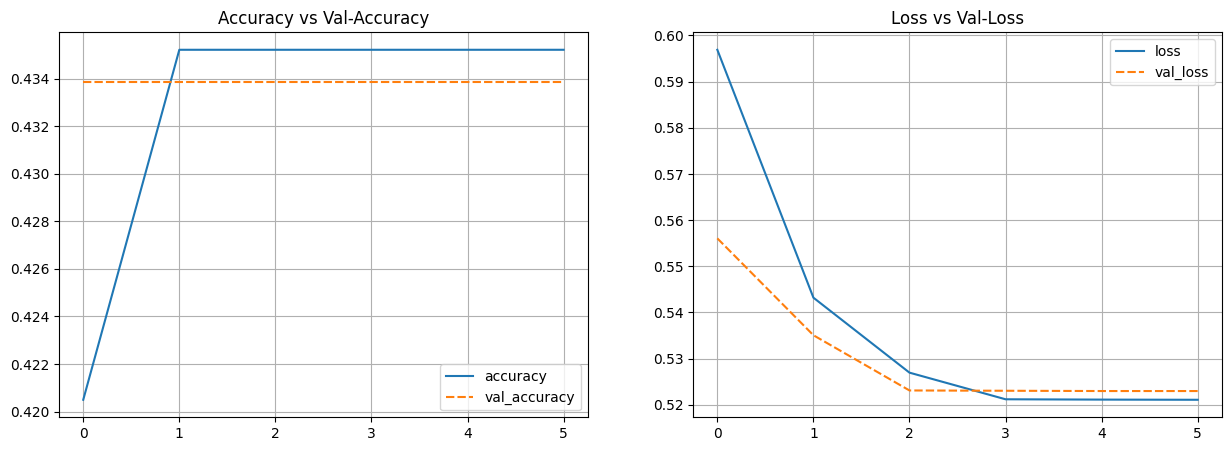

In [29]:
# Plot Training Results
model_lstm_1_hist_df = pd.DataFrame(model_lstm_1_hist.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=model_lstm_1_hist_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=model_lstm_1_hist_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.show()

- The training accuracy quickly plateaus at around 0.434 after the first epoch and remains flat, and the validation accuracy also remains flat around 0.434, showing no improvement during the training.
- The training loss decreases sharply in the first epoch and then gradually continues to decrease, reaching around 0.52, the validation loss follows a similar pattern, decreasing sharply initially and then stabilizing.

In [30]:
# Predict and evaluate model 1
y_pred = model_lstm_1.predict(X_test)
# y_pred_biner_1 = tf.where(y_pred_proba_1 >= 0.5, 1, 0)

y_pred[:,0] = tf.where(y_pred[:,0] > 0.1, 1, 0)  # Thresholding light complaints at 0.1
y_pred[:,1] = tf.where(y_pred[:,1] > 0.1, 1, 0)  # Thresholding harsh complaints at 0.1
y_pred[:,2] = tf.where(y_pred[:,2] > 0.75, 1, 0)  # Thresholding mild complaints at 0.75

report_1 = classification_report(y_test, y_pred, target_names=['light', 'harsh', 'mild'])

test_loss_1, test_accuracy_1 = model_lstm_1.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss_1}")
print(f"Test Accuracy: {test_accuracy_1}")
print(report_1)

11/11 [==============================] - 10s 881ms/step - loss: 0.5553 - accuracy: 0.4341
Test Loss: 0.5553115606307983
Test Accuracy: 0.4341317415237427
              precision    recall  f1-score   support

       light       0.19      1.00      0.32        64
       harsh       0.47      1.00      0.64       156
        mild       0.00      0.00      0.00       293

   micro avg       0.33      0.43      0.37       513
   macro avg       0.22      0.67      0.32       513
weighted avg       0.17      0.43      0.23       513
 samples avg       0.33      0.35      0.33       513



The base model shows high recall for the `light` and `harsh` categories but performs poorly on the `mild` category with no correct predictions. The accuracy and weighted metrics indicate the model is not well-calibrated, especially for the `mild` category.

## d. Model Improvements

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 400)               0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 400, 128)          1280000   
                                                                 
 bidirectional (Bidirection  (None, 400, 256)          263168    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               164352    
 onal)                                                           
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                        

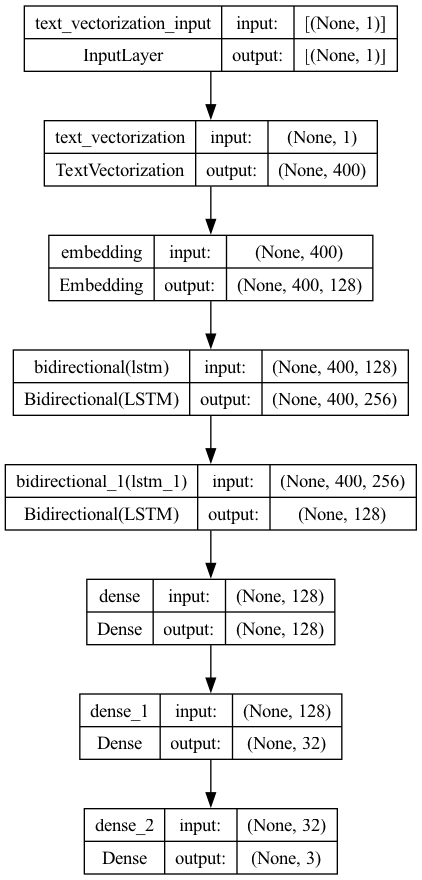

In [65]:
## Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

## Define the architecture
model_lstm_2 = Sequential()
model_lstm_2.add(text_vectorization)
model_lstm_2.add(embedding)
model_lstm_2.add(Bidirectional(LSTM(128, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_2.add(Bidirectional(LSTM(64, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_2.add(Dense(128, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal(seed)))
model_lstm_2.add(Dense(32, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal(seed)))
model_lstm_2.add(Dense(3, activation='sigmoid'))

# Ensure loss function is correct
model_lstm_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_lstm_2.summary()

# plot the model
plot_model(model_lstm_2, show_shapes=True, show_layer_names=True)

In [66]:
# Assign callback to speed up computing and reduce learning rate
callbacks= [
    EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        verbose=1,
        restore_best_weights=True
        ),
    ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.01,
        patience=2
        )
]

In [67]:
# model training
model_lstm_2_hist = model_lstm_2.fit(X_train,
                                     y_train,
                                     epochs=25,
                                     batch_size=32,
                                     validation_data=(X_val, y_val),
                                     callbacks=callbacks)

Epoch 1/25
54/54 [==============================] - 37s 560ms/step - loss: 0.4017 - accuracy: 0.4812 - val_loss: 0.4591 - val_accuracy: 0.5344 - lr: 0.0010
Epoch 2/25
54/54 [==============================] - 30s 554ms/step - loss: 0.2563 - accuracy: 0.5842 - val_loss: 0.4507 - val_accuracy: 0.5344 - lr: 0.0010
Epoch 3/25
54/54 [==============================] - 30s 556ms/step - loss: 0.1968 - accuracy: 0.5978 - val_loss: 0.4788 - val_accuracy: 0.5503 - lr: 0.0010
Epoch 4/25
54/54 [==============================] - 33s 604ms/step - loss: 0.1450 - accuracy: 0.6455 - val_loss: 0.5742 - val_accuracy: 0.5714 - lr: 0.0010
Epoch 5/25
54/54 [==============================] - 29s 544ms/step - loss: 0.1044 - accuracy: 0.6784 - val_loss: 0.5930 - val_accuracy: 0.5714 - lr: 0.0010
Epoch 6/25
54/54 [==============================] - 29s 530ms/step - loss: 0.0893 - accuracy: 0.6885 - val_loss: 0.6383 - val_accuracy: 0.5556 - lr: 0.0010
Epoch 7/25
54/54 [==============================] - 29s 535ms/st

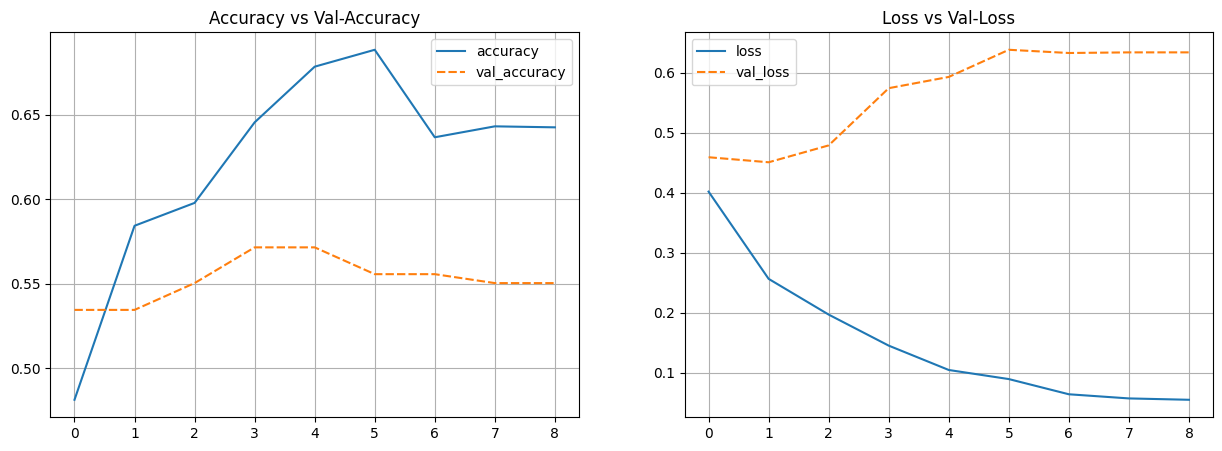

In [68]:
# Plot Training Results
model_lstm_2_hist_df = pd.DataFrame(model_lstm_2_hist.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=model_lstm_2_hist_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=model_lstm_2_hist_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.show()

- The training accuracy steadily increases and reaches around 0.65 at epoch 5 before slightly decreasing, the validation accuracy improves slightly but remains below 0.55 throughout the training process.
- The training loss decreases steadily, showing a clear improvement in minimizing the loss function, the validation loss, however, starts to increase after epoch 2, indicating potential overfitting where the model performs well on the training data but not on the validation data.

The tuned model has improved performance on the training data but does not significantly improve generalization to the validation data compared to the base model. This indicates that further tuning or regularization might be necessary to enhance the model's performance on unseen data.

In [69]:
# Predict and evaluate model 1
y_pred = model_lstm_2.predict(X_test)
# y_pred_biner_2 = tf.where(y_pred_proba_2 >= 0.5, 1, 0)

y_pred[:,0] = tf.where(y_pred[:,0] > 0.1, 1, 0)  # Thresholding light complaints at 0.1
y_pred[:,1] = tf.where(y_pred[:,1] > 0.1, 1, 0)  # Thresholding harsh complaints at 0.1
y_pred[:,2] = tf.where(y_pred[:,2] > 0.75, 1, 0)  # Thresholding mild complaints at 0.75

report_2 = classification_report(y_test, y_pred, target_names=['light', 'harsh', 'mild'])

test_loss_2, test_accuracy_2 = model_lstm_2.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss_2}")
print(f"Test Accuracy: {test_accuracy_2}")
print(report_2)

11/11 [==============================] - 2s 153ms/step - loss: 0.5732 - accuracy: 0.5778
Test Loss: 0.5732179880142212
Test Accuracy: 0.5778443217277527
              precision    recall  f1-score   support

       light       0.45      0.62      0.52        64
       harsh       0.62      0.83      0.71       156
        mild       0.95      0.89      0.92       293

   micro avg       0.75      0.84      0.79       513
   macro avg       0.67      0.78      0.72       513
weighted avg       0.79      0.84      0.80       513
 samples avg       0.81      0.87      0.81       513



The tuned model shows significant improvement across all categories, especially in the `mild` category, achieving high precision, recall, and F1-scores. The accuracy and weighted metrics are much higher compared to the base model, indicating a better-calibrated and more reliable performance.

From the improved model metrics, we can see that:
* f1-score for both `light` and `harsh` labels prediction are improved compared to base models.
* ``

# 6. Model Saving 

In [70]:
model_lstm_2.save('model.keras')

# 7. Conclusion

## Model Analysis

**Base Model Metrics**

From the base model metrics, we can see that:
* precision for predicting `light` and `harsh` label has low performance, implying that the model prediction still having many false positive.
* On the other hand, the model doesn' have any prediction performance for `mild` label.
* Overall accuracy for the model is 0.4341, meaning that overall accuracy is also in the low end side.
* In conclusion, the model are not usable yet to predict whether the complaint has light, harsh, or mild label on it.

**Improved Model Metrics**

From the improved model metrics, we can see that:
* precision